# Machine learning for Power System Stability Analysis

<p style="background-color:azure;padding:10px;border:2px solid lightsteelblue"><b>Author:</b> Petar Sarajcev, PhD (petar.sarajcev@fesb.hr)
<br>
University of Split, FESB, Department of Power Engineering <br>R. Boskovica 32, HR-21000 Split, Croatia, EU.</p>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from scipy import stats

In [3]:
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion

In [4]:
# Inline figures
%matplotlib inline

In [5]:
# Figure aesthetics
sns.set(context='notebook', style='white', font_scale=1.2)
sns.set_style('ticks', {'xtick.direction':'in', 'ytick.direction':'in'})

In [6]:
# ancilary function from: https://github.com/amueller/introduction_to_ml_with_python/blob/master/mglearn/tools.py
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f", fontsize=14):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center", fontsize=fontsize)
    return img

### Transformer diagnostic data and health index values

In [7]:
data = pd.read_csv('GridDictionary.csv')
data.head()

,WmG1,WmG2,WmG3,WmG4,WmG5,WmG6,WmG7,WmG8,WmG9,WmG10,...,VClvB35,VAlvB36,VClvB36,VAlvB37,VClvB37,VAlvB38,VClvB38,VAlvB39,VClvB39,Stability
0,1.00120,1.0036,1.0029,1.0056,1.0079,1.0061,1.0060,1.0024,1.0025,1.0043,...,0.99777,1.03670,1.03670,1.0650,1.0650,1.0936,1.0936,1.0191,1.0191,0
1,1.00110,1.0033,1.0025,1.0047,1.0068,1.0052,1.0051,1.0021,1.0022,1.0039,...,1.01680,1.05330,1.05330,1.0673,1.0673,1.0922,1.0922,1.0192,1.0192,0
2,1.00120,1.0038,1.0033,1.0063,1.0079,1.0124,1.0114,1.0029,1.0030,1.0046,...,0.81049,0.88406,0.88378,1.0322,1.0322,1.0796,1.0796,1.0081,1.0081,0
3,1.00090,1.0025,1.0018,1.0011,1.0023,1.0015,1.0014,1.0012,1.0011,1.0020,...,1.07040,1.08570,1.08570,1.0570,1.0570,1.0676,1.0676,1.0252,1.0252,0
4,0.99983,1.0003,1.0007,1.0008,1.0008,1.0010,1.0009,1.0006,1.0010,1.0009,...,1.00710,1.01330,1.01330,1.0053,1.0053,1.0111,1.0111,1.0003,1.0003,0


In [8]:
# Percentage of "ones" in the "Stability" column
print('There is {:.1f}% of unstable cases in the dataset!'.format(data['Stability'].sum()/float(len(data['Stability']))*100.))

There is 19.1% of unstable cases in the dataset!


### Select a random subset of the original data

In [9]:
# Select a random subset of the original dataset (without replacement)
#SUBSET_SIZE = 2000
#random_idx = np.random.choice(data.index, size=SUBSET_SIZE, replace=False)
#data = data.iloc[random_idx]

### Data preprocessing and splitting

In [10]:
# Training dataset
no_features = len(data.columns) - 1
X_data = data.iloc[:,0:no_features]  # features
print('X_data', X_data.shape)
y_data = data['Stability']
print('y_data', y_data.shape)

X_data (3120, 276)
y_data (3120,)


In [11]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.8, shuffle=True)

In [12]:
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (2496, 276)
y_train (2496,)
X_test (624, 276)
y_test (624,)


In [13]:
y_t = data[['Stability']].copy()
idx = y_test.index.values
y_t = y_t.loc[idx]
y_t.shape

(624, 1)

#### StandardScaler

In [14]:
# Standardize the input data
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### LogisticRegression

In [15]:
# Logistic Regression (with fixed hyper-parameters)
lreg = LR(C=100.,  # fixed "C" hyper-parameter
          multi_class='ovr', solver='newton-cg', n_jobs=-1)
lreg.fit(X_train, y_train)  # fit model to data
y_lr = lreg.predict_proba(X_test)  # predict on new data

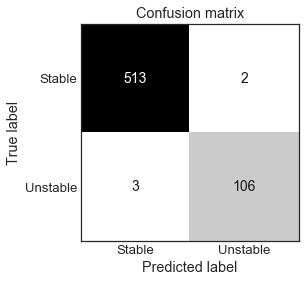

In [175]:
pred = lreg.predict(X_test)
labels = ['Stable', 'Unstable']
# confusion matrix
scores_image = heatmap(metrics.confusion_matrix(y_test, pred), xlabel='Predicted label', 
                       ylabel='True label', xticklabels=labels, yticklabels=labels, 
                       cmap=plt.cm.gray_r, fmt="%d")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()
plt.show()

In [17]:
# classification report
print(metrics.classification_report(y_test, pred, target_names=labels))

              precision    recall  f1-score   support

        Stab       0.99      1.00      1.00       515
     NotStab       0.98      0.97      0.98       109

    accuracy                           0.99       624
   macro avg       0.99      0.98      0.99       624
weighted avg       0.99      0.99      0.99       624



#### GridSearchCV

In [18]:
# Grid-search with cross validation for optimal model hyper-parameters
parameters = {'C':[1., 10., 50., 100., 500., 1000.]}
lreg = GridSearchCV(estimator=LR(multi_class='ovr', solver='newton-cg'), 
                    param_grid=parameters, cv=3, scoring='f1',  # notice the "scoring" method!
                    refit=True, n_jobs=-1, iid=False)
lreg.fit(X_train, y_train)
# Best value of hyper-parameter "C"
best_c = lreg.best_params_['C']
print('Best value: C = {:g}'.format(best_c))

Best value: C = 500


In [19]:
# Average classification accuracy with cross validation
scores = cross_val_score(LR(C=best_c, multi_class='ovr', solver='newton-cg'), 
                         X_train, y_train, cv=3)  # it doesn't return a model!
print('Score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Score using 3-fold CV: 0.992388 +/- 0.00299812


### Feature selection with Pipeline and GridSearch

In [20]:
# Optimize the number of features and the classifier's hyper-parameters 
# at the same time, using pipline and grid search with cross-validation
pca = PCA()  # do NOT set "n_components" here!
logreg = LR(multi_class='ovr', solver='newton-cg')  # multinomial classification!
pipe = Pipeline([('pca',pca), ('logreg',logreg)])
param_grid = {'pca__n_components': [10, 20, 50, 100],   # PCA
              'logreg__C': [10., 50., 100., 500.]}      # LogisticRegression
grid_pipe = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=3, 
                         scoring='f1', refit=True, n_jobs=-1, iid=False)
grid_pipe.fit(X_train, y_train)
print('Best parameter (CV score = {:0.3f}):'.format(grid_pipe.best_score_))
print(grid_pipe.best_params_)

Best parameter (CV score = 0.981):
{'logreg__C': 500.0, 'pca__n_components': 50}


In [21]:
# Predict probability on test data
y_lr = grid_pipe.predict_proba(X_test)
y_t['logreg'] = y_lr.argmax(axis=1)

In [22]:
y_t.head()

,Stability,logreg
1560,0,0
1136,1,1
97,0,0
210,0,0
930,0,0


### Support Vector Machine

In [23]:
parameters ={'C':[1., 10., 100., 500., 1000.],
             'gamma':[0.0001, 0.001, 0.01, 0.1, 1.]}
svc = GridSearchCV(estimator=svm.SVC(kernel='rbf', probability=True), 
                   param_grid=parameters, cv=3,
                   scoring='f1', refit=True, n_jobs=-1, iid=False)
svc.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid=False, n_jobs=-1,
             param_grid={'C': [1.0, 10.0, 100.0, 500.0, 1000.0],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [24]:
# Best model parameters
best_parameters = svc.best_params_
print("Best parameters from GridSearch: {}".format(svc.best_params_))

Best parameters from GridSearch: {'C': 500.0, 'gamma': 0.01}


In [25]:
scores = cross_val_score(svm.SVC(**best_parameters), X_train, y_train, cv=3)
print('Average score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Average score using 3-fold CV: 0.99399 +/- 0.000981366


In [26]:
results = pd.DataFrame(svc.cv_results_)
scores = np.array(results.mean_test_score).reshape(len(parameters['C']), len(parameters['gamma']))

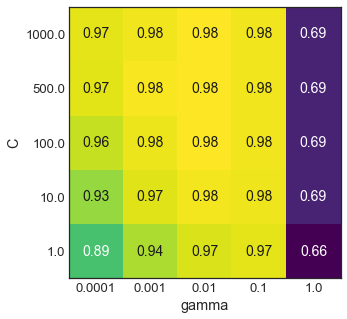

In [27]:
fig, ax = plt.subplots(figsize=(5,5))
heatmap(scores, xlabel='gamma', xticklabels=parameters['gamma'], 
        ylabel='C', yticklabels=parameters['C'], cmap="viridis", ax=ax)
plt.show()

#### RandomizedSearchCV

In [28]:
parameters = {'C':stats.expon(scale=100), 'gamma':stats.expon(scale=.1)}
svc2 = RandomizedSearchCV(estimator=svm.SVC(kernel='rbf', probability=True), 
                          param_distributions=parameters, cv=3, n_iter=50,  # 50 iterations!
                          scoring='f1',  # notice the scoring method!
                          refit=True, n_jobs=-1, iid=False)
svc2.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, probability=True,
                                 random_state=None, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid=False, n_iter=50, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f92776f9208>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f92776f9a58>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='f1', verbose=0)

In [29]:
# Best model parameters
best_parameters = svc2.best_params_
print("Best parameters from RandomSearch: {}".format(svc2.best_params_))

Best parameters from RandomSearch: {'C': 504.98699909148553, 'gamma': 0.009589513270161203}


In [30]:
scores = cross_val_score(svm.SVC(**best_parameters), X_train, y_train, cv=3)
print('Average score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Average score using 3-fold CV: 0.99399 +/- 0.000981366


In [31]:
y_svc2 = svc2.predict_proba(X_test)
y_t['svc'] = y_svc2.argmax(axis=1)

#### Precision-Recall Tradeoff

In [32]:
y_probas = cross_val_predict(svm.SVC(**best_parameters, probability=True), 
                             X_train, y_train, cv=3, method='predict_proba')
y_scores = y_probas[:,1]  # score = probability of positive class

In [33]:
precisions, recalls, thresholds = metrics.precision_recall_curve(y_train, y_scores)

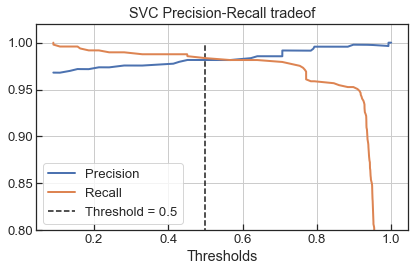

In [34]:
fig, ax = plt.subplots(figsize=(6,4))
ax.set_title('SVC Precision-Recall tradeof')
ax.plot(thresholds, precisions[:-1], lw=2, label='Precision')
ax.plot(thresholds, recalls[:-1], lw=2, label='Recall')
plt.vlines(0.5, 0, 1, linestyles='--', label='Threshold = 0.5')
ax.set_xlabel('Thresholds')
ax.legend(loc='best')
ax.set_ylim(bottom=0.8, top=1.02)
ax.grid()
fig.tight_layout()
plt.show()

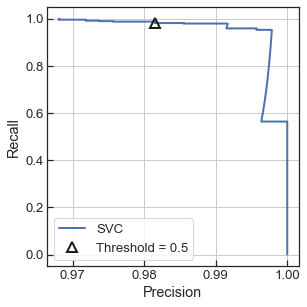

In [35]:
fig, ax = plt.subplots(figsize=(4.5,4.5))
ax.plot(precisions, recalls, lw=2, label='SVC')
default = np.argmin(np.abs(thresholds - 0.5))
ax.plot(precisions[default], recalls[default], '^', c='k', markersize=10, 
        label='Threshold = 0.5', fillstyle='none', mew=2)
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.legend(loc='best')
ax.grid()
fig.tight_layout()
plt.show()

In [36]:
# Average precision-recall score
y_test_score = svc2.predict_proba(X_test)[:,1]
average_precision = metrics.average_precision_score(y_test, y_test_score)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.99


In [37]:
# Determine a class from the predicted probability by using 
# the user-specified threshold value (not a default of 0.5)
THRESHOLD = 0.6
preds = np.where(y_test_score > THRESHOLD, 1, 0)

In [38]:
pd.DataFrame(data=[metrics.accuracy_score(y_test, preds), metrics.recall_score(y_test, preds),
                   metrics.precision_score(y_test, preds), metrics.roc_auc_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

,0
accuracy,0.998397
recall,0.990826
precision,1.000000
roc_auc_score,0.995413


### ExtraTreesClassifier

In [40]:
# ExtraTreesClassifier (ensemble learner) with grid search 
# and cross-validation for hyper-parameters optimisation
parameters = {'n_estimators':[5, 10, 15, 20], 
              'criterion':['gini', 'entropy'], 
              'max_depth':[2, 5, None]}
trees = GridSearchCV(estimator=ExtraTreesClassifier(), param_grid=parameters, 
                     cv=3, scoring='f1', refit=True, n_jobs=-1, iid=False) 
trees.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None,
                                            criterion='gini', max_depth=None,
                                            max_features='auto',
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators='warn', n_jobs=None,
                                            oob_score=False, random_state=None,
                                            verbose=0, warm_start=False),
             iid=False, n_jobs=-1,
             param_grid={'criterion': ['gini', 'en

In [41]:
# Best model parameters
best_parameters = trees.best_params_
print("Best parameters: {}".format(trees.best_params_))

Best parameters: {'criterion': 'gini', 'max_depth': None, 'n_estimators': 20}


In [42]:
scores = cross_val_score(ExtraTreesClassifier(**best_parameters), X_train, y_train, cv=3)
print('Average score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Average score using 3-fold CV: 0.991987 +/- 0.00113318


In [43]:
y_trees = trees.predict_proba(X_test)
y_t['tree'] = y_trees.argmax(axis=1)

### RandomForest classifier (ensemble learner)

In [44]:
# RandomForestClassifier (ensemble learner for classification)
parameters = {'n_estimators':[10, 15, 20], 
              'criterion':['gini', 'entropy'],
              'max_features':[4, 'auto'],
              'max_depth':[2, None]}
# grid search and cross-validation for hyper-parameters optimisation
forest = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameters, 
                      cv=3, scoring='f1', refit=True, n_jobs=-1, iid=False) 
forest.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [45]:
best_parameters = forest.best_params_
print("Best parameters: {}".format(forest.best_params_))

Best parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 15}


In [46]:
scores = cross_val_score(RandomForestClassifier(**best_parameters), X_train, y_train, cv=3)
print('Average score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Average score using 3-fold CV: 0.992388 +/- 0.00283296


In [47]:
y_forest = forest.predict_proba(X_test)
y_t['forest'] = y_forest.argmax(axis=1)

### GradientBoosting classifier with feature importance analysis

In [48]:
# Train & evaluate model performance
def train_and_evaluate(model, X, y, ns=3):
    # k-fold cross validation iterator 
    cv = KFold(n_splits=ns, shuffle=True)
    scores = cross_val_score(model, X, y, cv=cv, scoring='f1')  # scoring method is f1!
    print('Average score using {:d}-fold CV: {:g} +/- {:g}'.format(ns, np.mean(scores), np.std(scores)))

In [49]:
# Gradient Boosting Classifier
clf_gb = GradientBoostingClassifier()
train_and_evaluate(clf_gb, X_train, y_train, 3)
clf_gb.fit(X_train, y_train)

Average score using 3-fold CV: 0.984562 +/- 0.00665141


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [50]:
# Feature importance
feature_importance = clf_gb.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

In [55]:
# Select top features
TOP = 10
top_features = data.columns.values[sorted_idx][-TOP:][::-1]
print('Most relevant {:d} features according to the GradientBoostingClassifier:'.format(TOP))
print(top_features)

Most relevant 10 features according to the GradientBoostingClassifier:
['IqG7' 'IqG9' 'IqG6' 'VtG5' 'IdG9' 'PlvG6' 'PlvG9' 'VtG3' 'VAlvB12'
 'IqG3']


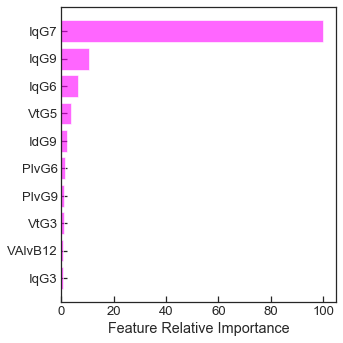

In [52]:
# Plot relative feature importance
fig, ax = plt.subplots(figsize=(5,5))
ax.barh(pos[-TOP:], feature_importance[sorted_idx][-TOP:], align='center', color='magenta', alpha=0.6)
plt.yticks(pos[-TOP:], data.columns[sorted_idx][-TOP:])
ax.set_xlabel('Feature Relative Importance')
#ax.grid(which='major', axis='x')
plt.tight_layout()
plt.show()

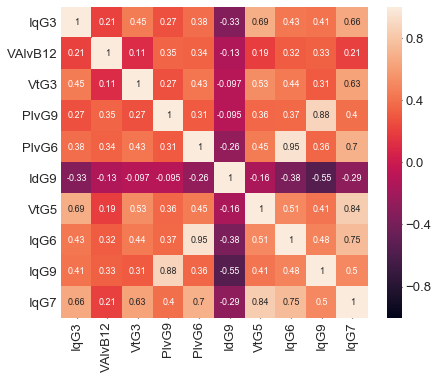

In [53]:
# Correlation matrix of selected features
pearson = data[data.columns[sorted_idx][-TOP:]].corr('pearson')
pearson.iloc[-1][:-1].sort_values()
# Correlation matrix as heatmap (seaborn)
fig, ax = plt.subplots(figsize=(6.5,5.5))
sns.heatmap(pearson, annot=True, annot_kws=dict(size=9), vmin=-1, vmax=1, ax=ax)
plt.tight_layout()
plt.show()

In [54]:
# Predict on new data
y_gb = clf_gb.predict_proba(X_test)
y_t['gbr'] = y_gb.argmax(axis=1)

### Re-train SVM using only top features from the GradientBoosting classifier

In [157]:
# IMPORTANT: NTOP <= TOP
NTOP = 2  # using only top 2 features!

In [125]:
top_features_index = []
for name in top_features:
    top_features_index.append(data.columns.get_loc(name))

In [158]:
X_train_best = X_train[:,top_features_index[:NTOP]]
X_test_best = X_test[:,top_features_index[:NTOP]]
print(X_train_best.shape)
print(X_test_best.shape)

(2496, 2)
(624, 2)


In [159]:
# Optimize SVM with only TOP features
parameters = {'C':stats.expon(scale=100), 'gamma':stats.expon(scale=.1)}
svc_top = RandomizedSearchCV(estimator=svm.SVC(kernel='rbf', probability=True), 
                             param_distributions=parameters, cv=3, n_iter=50,  # 50 iterations!
                             scoring='f1',  # notice the scoring method!
                             refit=True, n_jobs=-1, iid=False)
svc_top.fit(X_train_best, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, probability=True,
                                 random_state=None, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid=False, n_iter=50, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f925a15fe10>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f925a15fd68>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='f1', verbose=0)

In [160]:
# Best model parameters
best_parameters = svc_top.best_params_
print("Best parameters from RandomSearch: {}".format(svc_top.best_params_))

Best parameters from RandomSearch: {'C': 111.17633418995874, 'gamma': 0.26275934488954594}


In [161]:
scores = cross_val_score(svm.SVC(**best_parameters), X_train_best, y_train, cv=3)
print('Average score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Average score using 3-fold CV: 0.97476 +/- 0.00855535


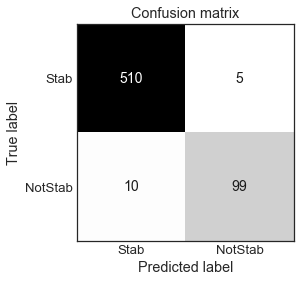

In [174]:
# confusion matrix
scores_image = heatmap(metrics.confusion_matrix(y_test, svc_top.predict(X_test_best)), 
                       xlabel='Predicted label', ylabel='True label', 
                       xticklabels=labels, yticklabels=labels, 
                       cmap=plt.cm.gray_r, fmt="%d")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()
plt.show()

In [162]:
print(metrics.classification_report(y_test, svc_top.predict(X_test_best), target_names=labels))

              precision    recall  f1-score   support

        Stab       0.98      0.99      0.99       515
     NotStab       0.95      0.91      0.93       109

    accuracy                           0.98       624
   macro avg       0.97      0.95      0.96       624
weighted avg       0.98      0.98      0.98       624



#### Graphical visualization of the top two features

In [163]:
x_vals_0 = data[top_features[0]].loc[data['Stability']==0]
x_vals_1 = data[top_features[0]].loc[data['Stability']==1]
y_vals_0 = data[top_features[1]].loc[data['Stability']==0]
y_vals_1 = data[top_features[1]].loc[data['Stability']==1]

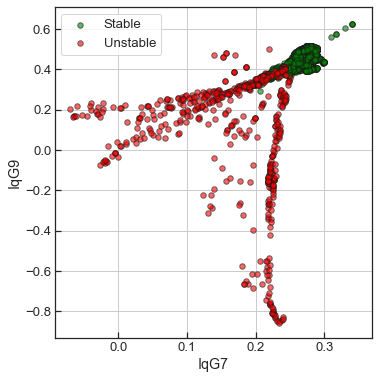

In [164]:
fig, ax = plt.subplots(figsize=(5.5,5.5))
ax.scatter(x_vals_0, y_vals_0, s=30, c='green', marker='o', edgecolors='k', alpha=0.6, label='Stable')
ax.scatter(x_vals_1, y_vals_1, s=30, c='red', marker='o', edgecolors='k', alpha=0.6, label='Unstable')
ax.legend(loc='best')
ax.set_xlabel(top_features[0])
ax.set_ylabel(top_features[1])
ax.grid()
fig.tight_layout()
plt.show()

#### Plot decision region with only top two features (NTOP = 2)

In [165]:
# Axis grid with NTOP = 2
x_min, x_max = X_train_best[:,0].min() - 0.1, X_train_best[:,0].max() + 0.1
y_min, y_max = X_train_best[:,1].min() - 0.1, X_train_best[:,1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

In [166]:
Z = svc_top.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
Z = Z.reshape(xx.shape)

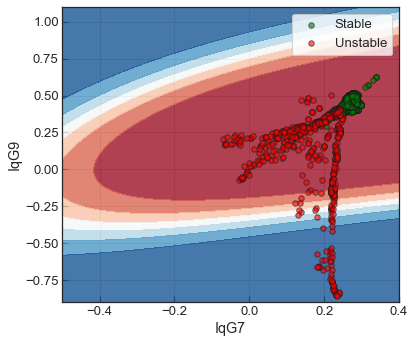

In [171]:
fig, ax = plt.subplots(figsize=(6,5))
ax.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.8)
ax.scatter(x_vals_0, y_vals_0, s=30, c='green', marker='o', edgecolors='k', alpha=0.6, label='Stable')
ax.scatter(x_vals_1, y_vals_1, s=30, c='red', marker='o', edgecolors='k', alpha=0.6, label='Unstable')
ax.legend(loc='best')
ax.set_xlabel(top_features[0])
ax.set_ylabel(top_features[1])
ax.set_xlim(-0.5, 0.4)
ax.set_ylim(-0.9, 1.1)
ax.grid()
fig.tight_layout()
plt.show()

## Ensemble models using voting principle

<p style="background-color:honeydew;padding:10px;border:2px solid mediumseagreen"><b>Note:</b> Ensembling consists of pooling together the predictions of a set of different models, to produce better predictions. The key to making ensembling work is the diversity of the set of classifiers. Diversity is what makes ensembling work. For this reason, one should ensemble models that are as good as possible while being <b>as different as possible</b>. This typically means using very different network architectures or even different brands of machine-learning approaches. This is exactly what has been proposed here.</p>

### Soft voting

In [54]:
clf = VotingClassifier(estimators=[('logreg', lreg),     # LogisticRegression
                                   ('svm', svc2),        # SVC
                                   ('forest', forest)],  # RandomForest 
                       weights=[1, 1, 1],  # classifier relative weights
                       voting='soft')
clf = clf.fit(X_train, y_train)

In [55]:
y_clf = clf.predict_proba(X_test)
y_t['vote'] = y_clf.argmax(axis=1)

In [56]:
scores = cross_val_score(clf, X_train, y_train, cv=3)
print('Average score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Average score using 3-fold CV: 0.992788 +/- 0.000981366


#### Predictions using individual classifiers and ensembles

In [57]:
y_t.head(10)

,Stability,logreg,svc,tree,forest,gbr,vote
190,0,0,0,0,0,0,0
2749,0,0,0,0,0,0,0
2894,0,0,0,0,0,0,0
2440,1,1,1,1,1,1,1
2743,0,0,0,0,0,0,0
562,1,1,1,1,1,1,1
1176,0,0,0,0,0,0,0
1659,0,0,0,0,0,0,0
2464,1,1,1,1,1,1,1
1213,1,1,1,1,1,1,1


In [176]:
import sys, IPython, platform, sklearn, scipy
print("Notebook createad on {:s} computer running {:s} and using:\
      \nPython {:s}\nIPython {:s}\nScikit-learn {:s}\nPandas {:s}\nNumpy {:s}\nScipy {:s}"\
      .format(platform.machine(), ' '.join(platform.dist()[:2]), sys.version[:5], 
              IPython.__version__, sklearn.__version__, pd.__version__, np.__version__, scipy.__version__))

Notebook createad on x86_64 computer running debian buster/sid and using:      
Python 3.7.3
IPython 7.7.0
Scikit-learn 0.21.2
Pandas 0.25.0
Numpy 1.16.4
Scipy 1.3.1


/home/ps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  after removing the cwd from sys.path.
